# Data Exploration and preporcessing

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import stft
from scipy.fft import fft,rfft, fftfreq, rfftfreq
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import librosa
import librosa.display
import json


from google.colab import drive
import glob

## Mounting Google Drive and copying data

In [2]:
# Mounting drive
drive.mount('/content/drive')
# Viewing the data in the folder present from the drive
!ls "/content/drive/My Drive/motor_noise_classifier/data"

# copying audio data from Google drive
!cp -r '/content/drive/My Drive/motor_noise_classifier/data' audio_data

# importing custom functions
!cp -r '/content/drive/My Drive/motor_noise_classifier/my_functions.py' my_functions.py
from my_functions import * 

Mounted at /content/drive
10.1.wav  12.1.wav  15.1.wav  18.1.wav	21.1.wav  23.1.wav  5.1.wav  8.1.wav
11.1.wav  13.1.wav  16.1.wav  19.1.wav	2.1.wav   3.1.wav   6.1.wav  9.1.wav
1.1.wav   14.1.wav  17.1.wav  20.1.wav	22.1.wav  4.1.wav   7.1.wav


## Data Exploration

### Reading data

#### Samplerate

In [3]:
random_sample = np.random.randint(1,23)
samplerate, signal = wavfile.read(f'./audio_data/{random_sample}.1.wav')
print(f'Samplerate = {samplerate}\n\n')

step = 1/samplerate
x = np.arange(0, len(signal)*step, step=step)

Samplerate = 44100




### Initial visualisation

- Channel 1 - acoustic signal
- Channel 2 - mechanical vibrations

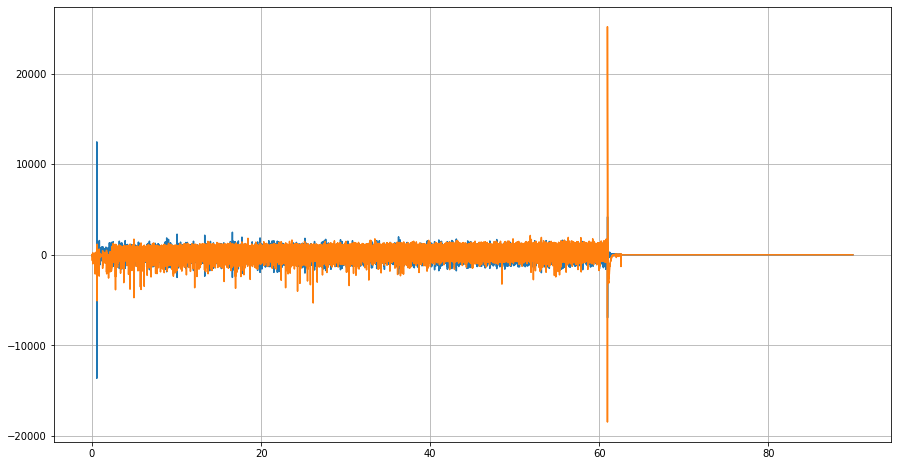

In [4]:
plt.figure(figsize=[15,8])
plt.plot(x, signal[:,0], x, signal[:,1])
plt.grid()
plt.show()

###  Identification of sudden jumps in the beginning and the end of timeserie

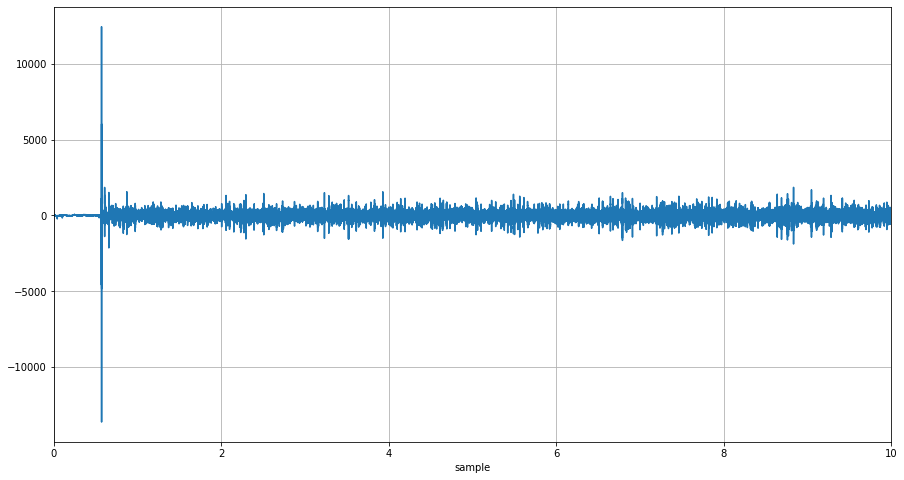

In [5]:
plt.figure(figsize=[15,8])
plt.plot(x, signal[:,0])
# plt.xlim([58,62])
plt.xlim([0,10]) 
# plt.ylim([-10000, 10000])
plt.xlabel("sample")
plt.grid()
plt.show()

In [6]:
x = np.arange(0, len(signal)*step, step=step)

# limiting data from 5s to 55s
leftLim = 5
leftLimId = int(leftLim / step)

rightLim = 55
rightLimId = int(rightLim / step)

print(f'left boundry Id = {leftLimId} \nright boundry Id = {rightLimId}')

x = x[leftLimId:rightLimId]
print(f'\nFinal sample number - {len(x)}')

left boundry Id = 220500 
right boundry Id = 2425500

Final sample number - 2205000


### Read all acoustic signals

In [7]:
motors = []
nbOfMotors = 23
goodBadBoundry = 10

for i in range(1,nbOfMotors + 1):
    signal = wavfile.read(f'./audio_data/{i}.1.wav')[1] # samplerate on 0 index, signal on index 1 
    signal_trimmed = signal[leftLimId:rightLimId,0]
    
    if i > goodBadBoundry:
        isGood = False
    else:
        isGood = True
    
    motor = Motor(isGood, signal_trimmed, i)
    motors.append(motor)

## Normalization of signals

In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))

for motor in motors:
    motor.signal = motor.signal.reshape(-1,1)
    motor.signal = scaler.fit_transform( motor.signal)
    # squeezing the redundant dimension (2205000, 1) -> (2205000,) 
    motor.signal = np.squeeze(motor.signal)

### Data visualisation

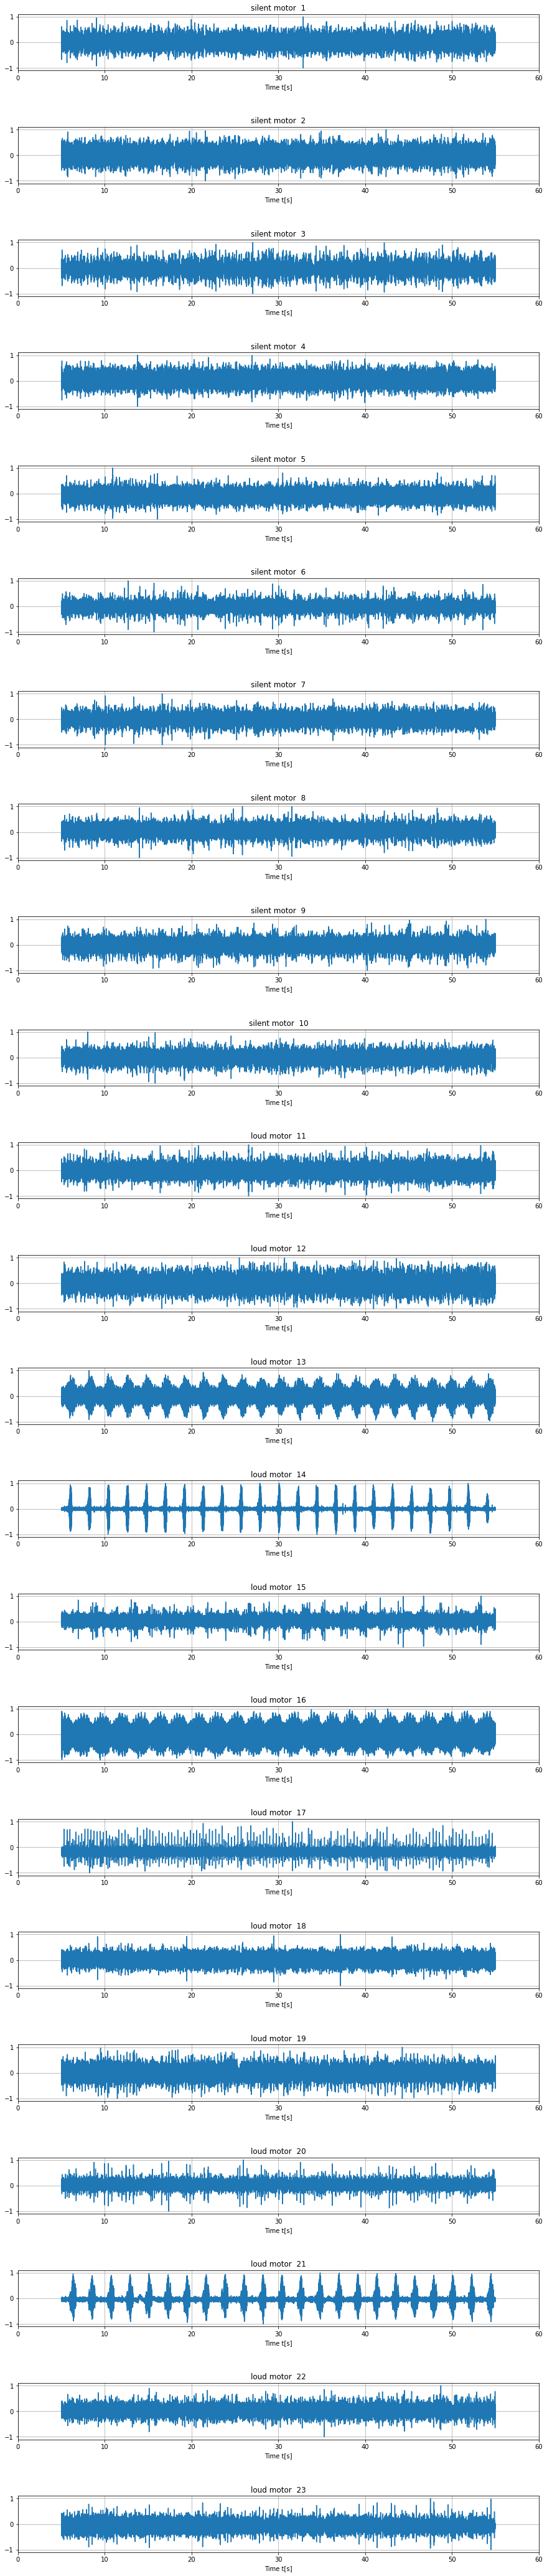

In [9]:
# create graphs folder 
!mkdir graphs

# signals after normalisation
printAllMotorsGraphs(x, motors, 
                     motor_feature='signal', 
                     x_lim=[0,60], 
                     save_pdf=True, 
                     pdf_title='signal_time_domain_normalised')

## FFT Analysis

In [10]:
for motor in motors:
    FFT = rfft(motor.signal)[1:]
    motor.FFT = np.abs(FFT)

N = len(x) # number of samples
freqs = rfftfreq(N, step)[1:] # weird things happening for freqency f=0

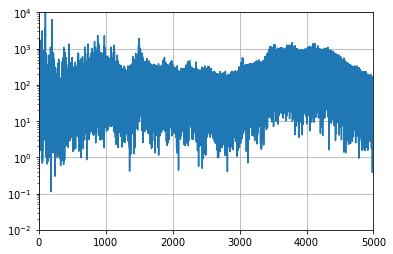

In [11]:
plt.semilogy(freqs, np.abs(motors[random_sample].FFT))
# plt.plot(freqs, np.abs(motors[10].FFT))

plt.grid()
plt.xlim([0, 5000])
# plt.ylim([0, 8000])
plt.ylim([10**(-2), 10**4])

plt.show()

### Graphs lin-lin scale

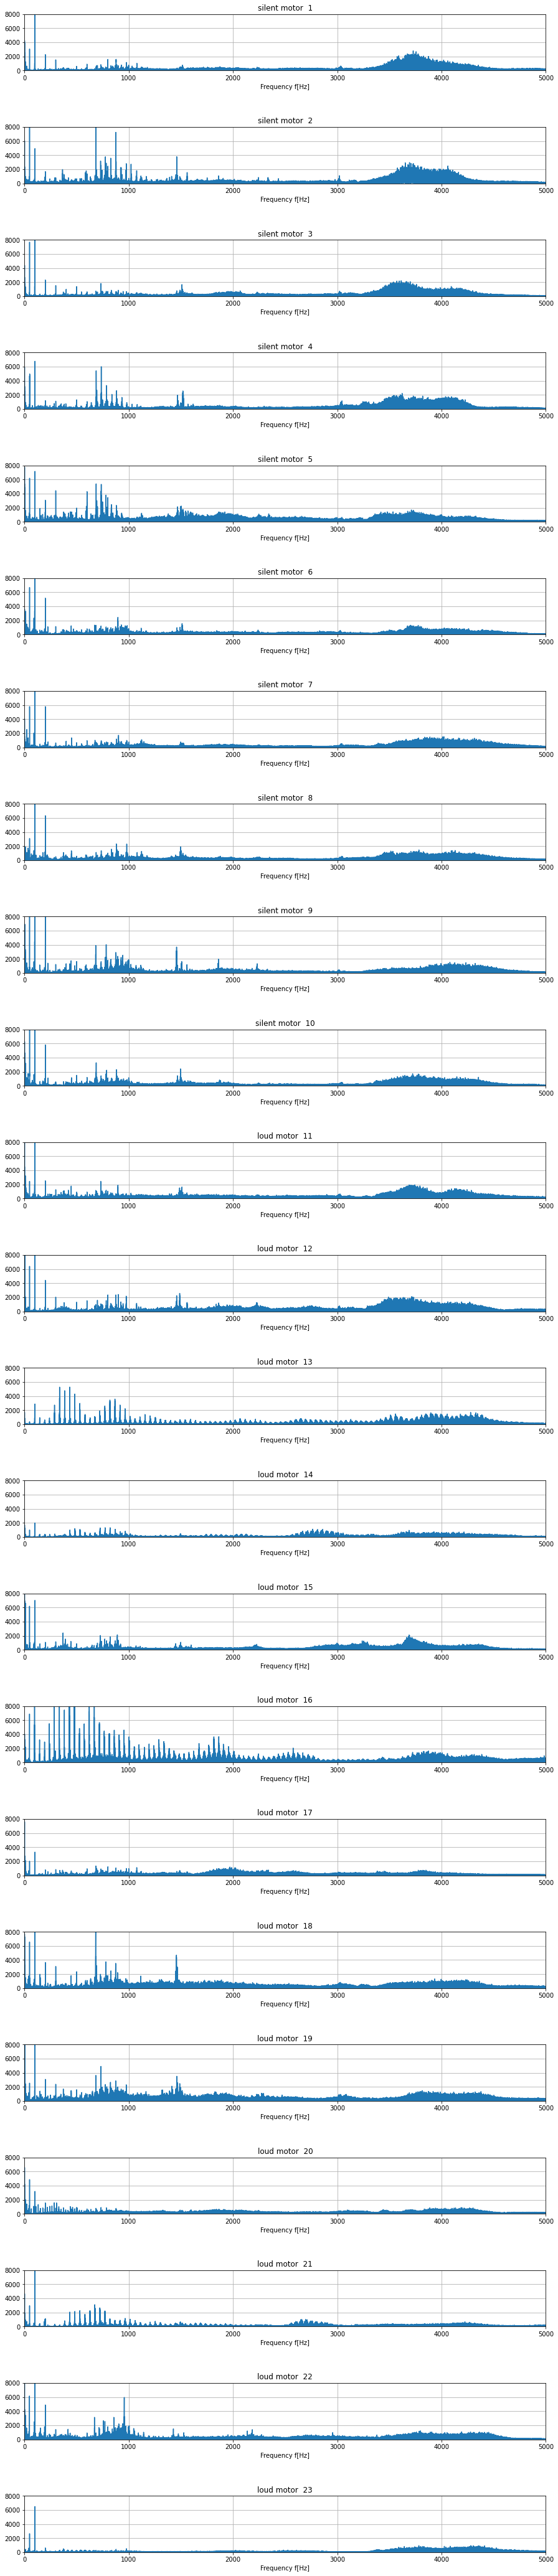

In [12]:
x_lim = [0,5000]
y_lim = [0,8000]

printAllMotorsGraphs(freqs, motors, motor_feature='FFT', domain='frequency', x_lim=x_lim, y_lim=y_lim, 
                         save_pdf=True, pdf_title='signal_freq_domain_lin')

### Graphs lin-log scale

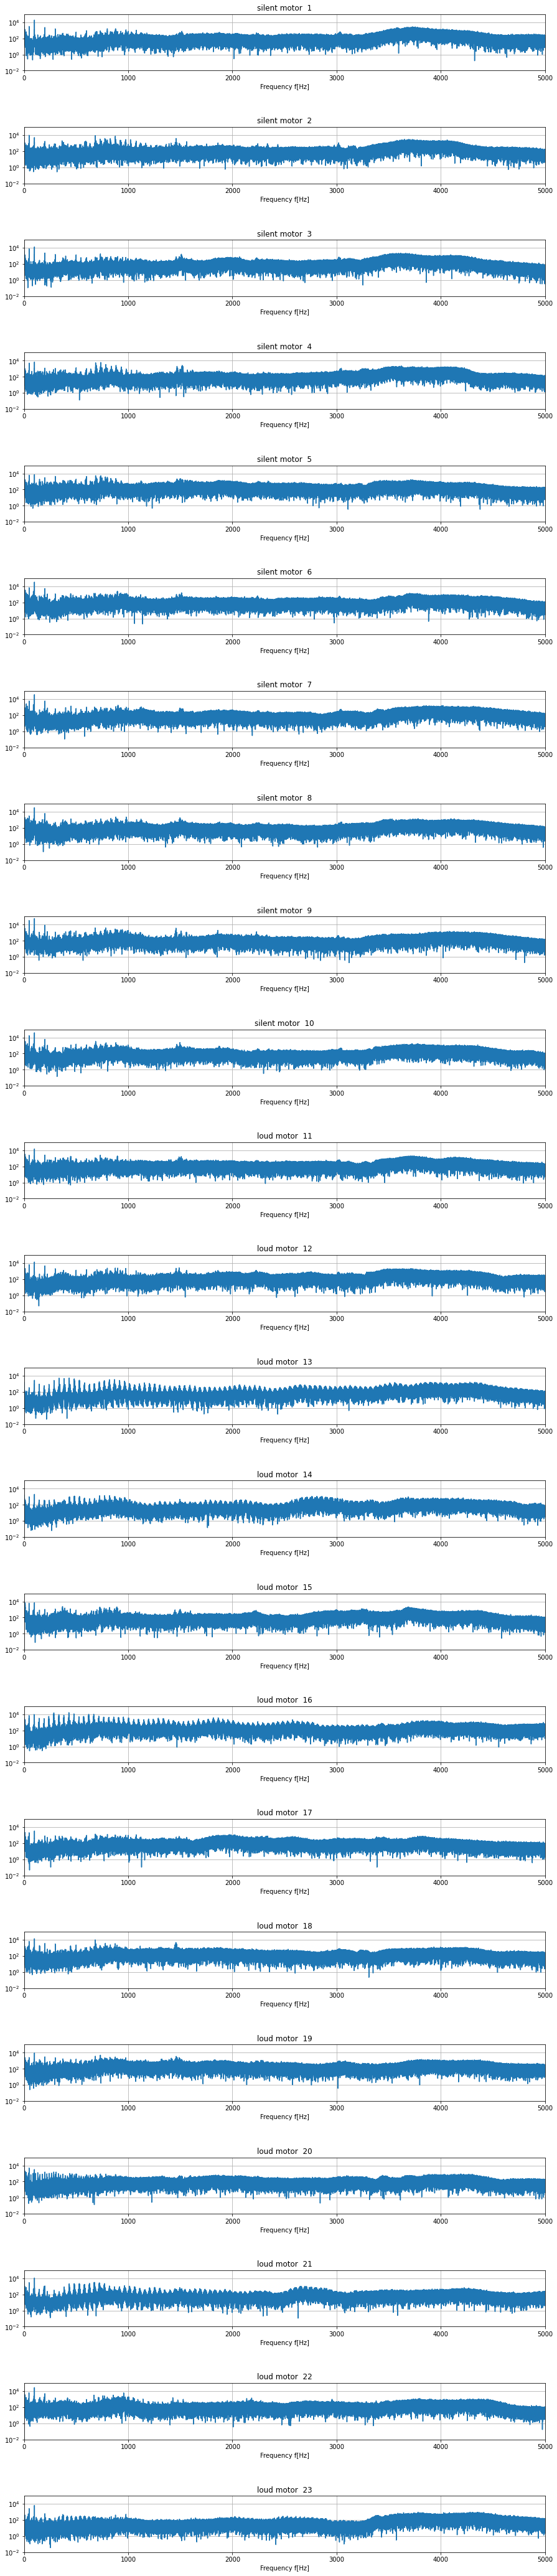

In [13]:
x_lim = [0,5000]
y_lim = [10**(-2), 10**5]

printAllMotorsGraphs(freqs, motors, 
                     motor_feature='FFT', 
                     domain='frequency', 
                     x_lim=x_lim, 
                     y_lim=y_lim, 
                     save_pdf=True, 
                     pdf_title='signal_freq_domain_log', 
                     y_axis='log')

## Segmentation of signals

In [14]:
segment_length = 1 #s

segments = []
for motor in motors:
    segments += motor.createSegments(segment_length,
                                     shift=segment_length/4)

np.shape(segments)

(4531,)



## Spectrogram

**Time / frequency trade off** [link](https://youtu.be/-Yxj3yfvY-4?list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&t=1613)

- decreasing frame size - decreasing freq resolution and increasing time resolution
- increasing frame size - increasing freq resolution and decreasing time resolution

In [15]:
N_FFT = 2**11  # needs to be power of 2 for DFT efficiency, high N_FFT -> high frequency resolution
HOP_SIZE = N_FFT//2
print(f'window/frame size = {N_FFT}\nhop_size = {HOP_SIZE}')

window/frame size = 2048
hop_size = 1024


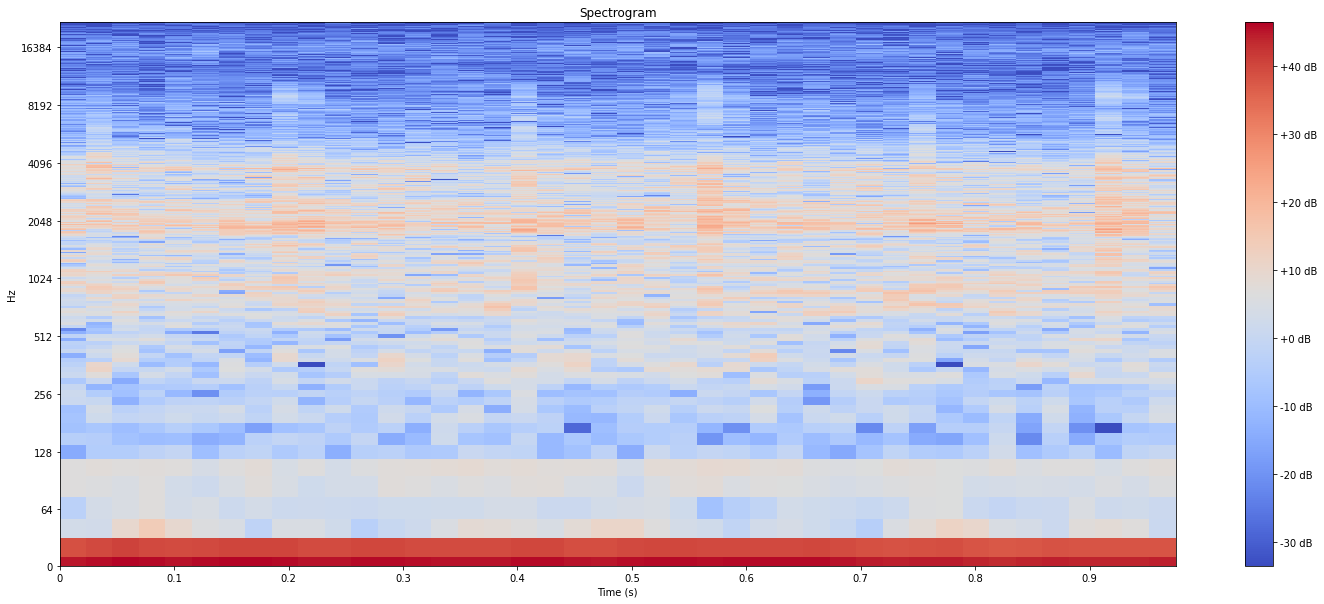

In [16]:
example_segment = segments[np.random.randint(len(segments))]
spec_dB = example_segment.createSpectrogram(n_fft=N_FFT, hop_length=HOP_SIZE)
example_segment.displaySpectrogram(hop_length=HOP_SIZE)

## Melspectrogram

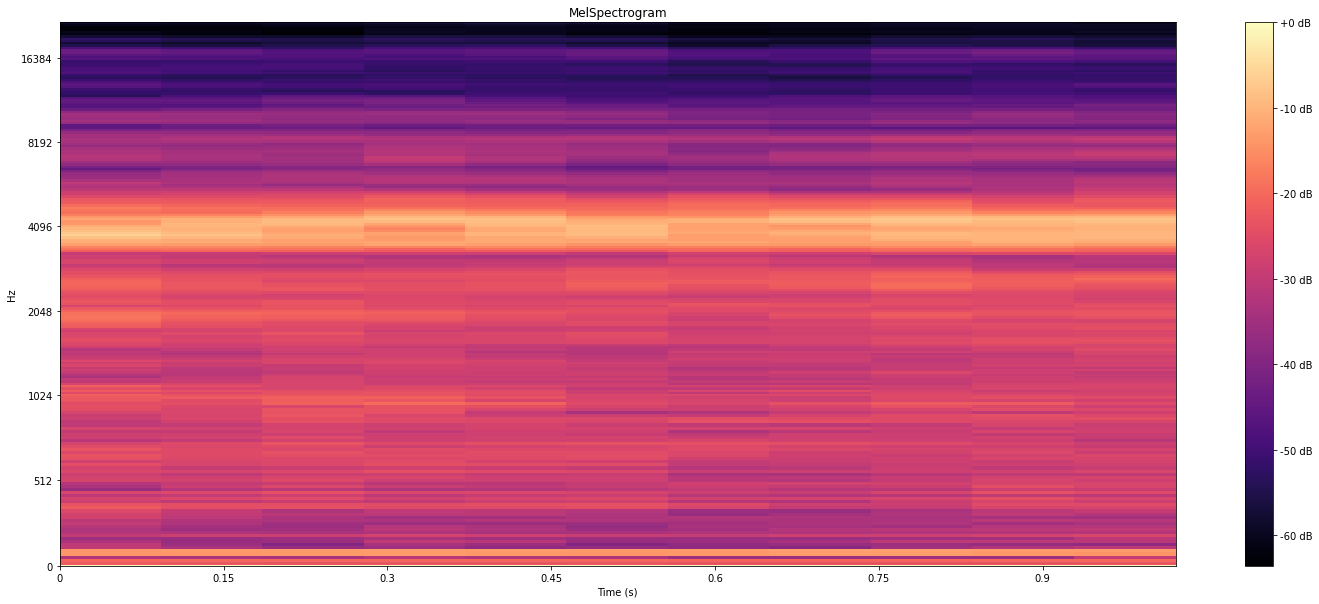

Melspectrogram shape: (220, 11)


In [ ]:
N_FFT = 2**14  # needs to be power of 2 for DFT efficiency, high N_FFT -> high frequency resolution
HOP_SIZE = N_FFT//4

n_mels = 220
example_segment.createMelSpectrogram(n_mels,
                                     n_fft=N_FFT,
                                     hop_length=HOP_SIZE)

example_segment.displaySpectrogram(spec_type='mel',
                                   title='MelSpectrogram', 
                                   hop_length=HOP_SIZE)
print(f'Melspectrogram shape: {np.shape(example_segment.mel_spec_dB)}')

### Melspectrograms comparison

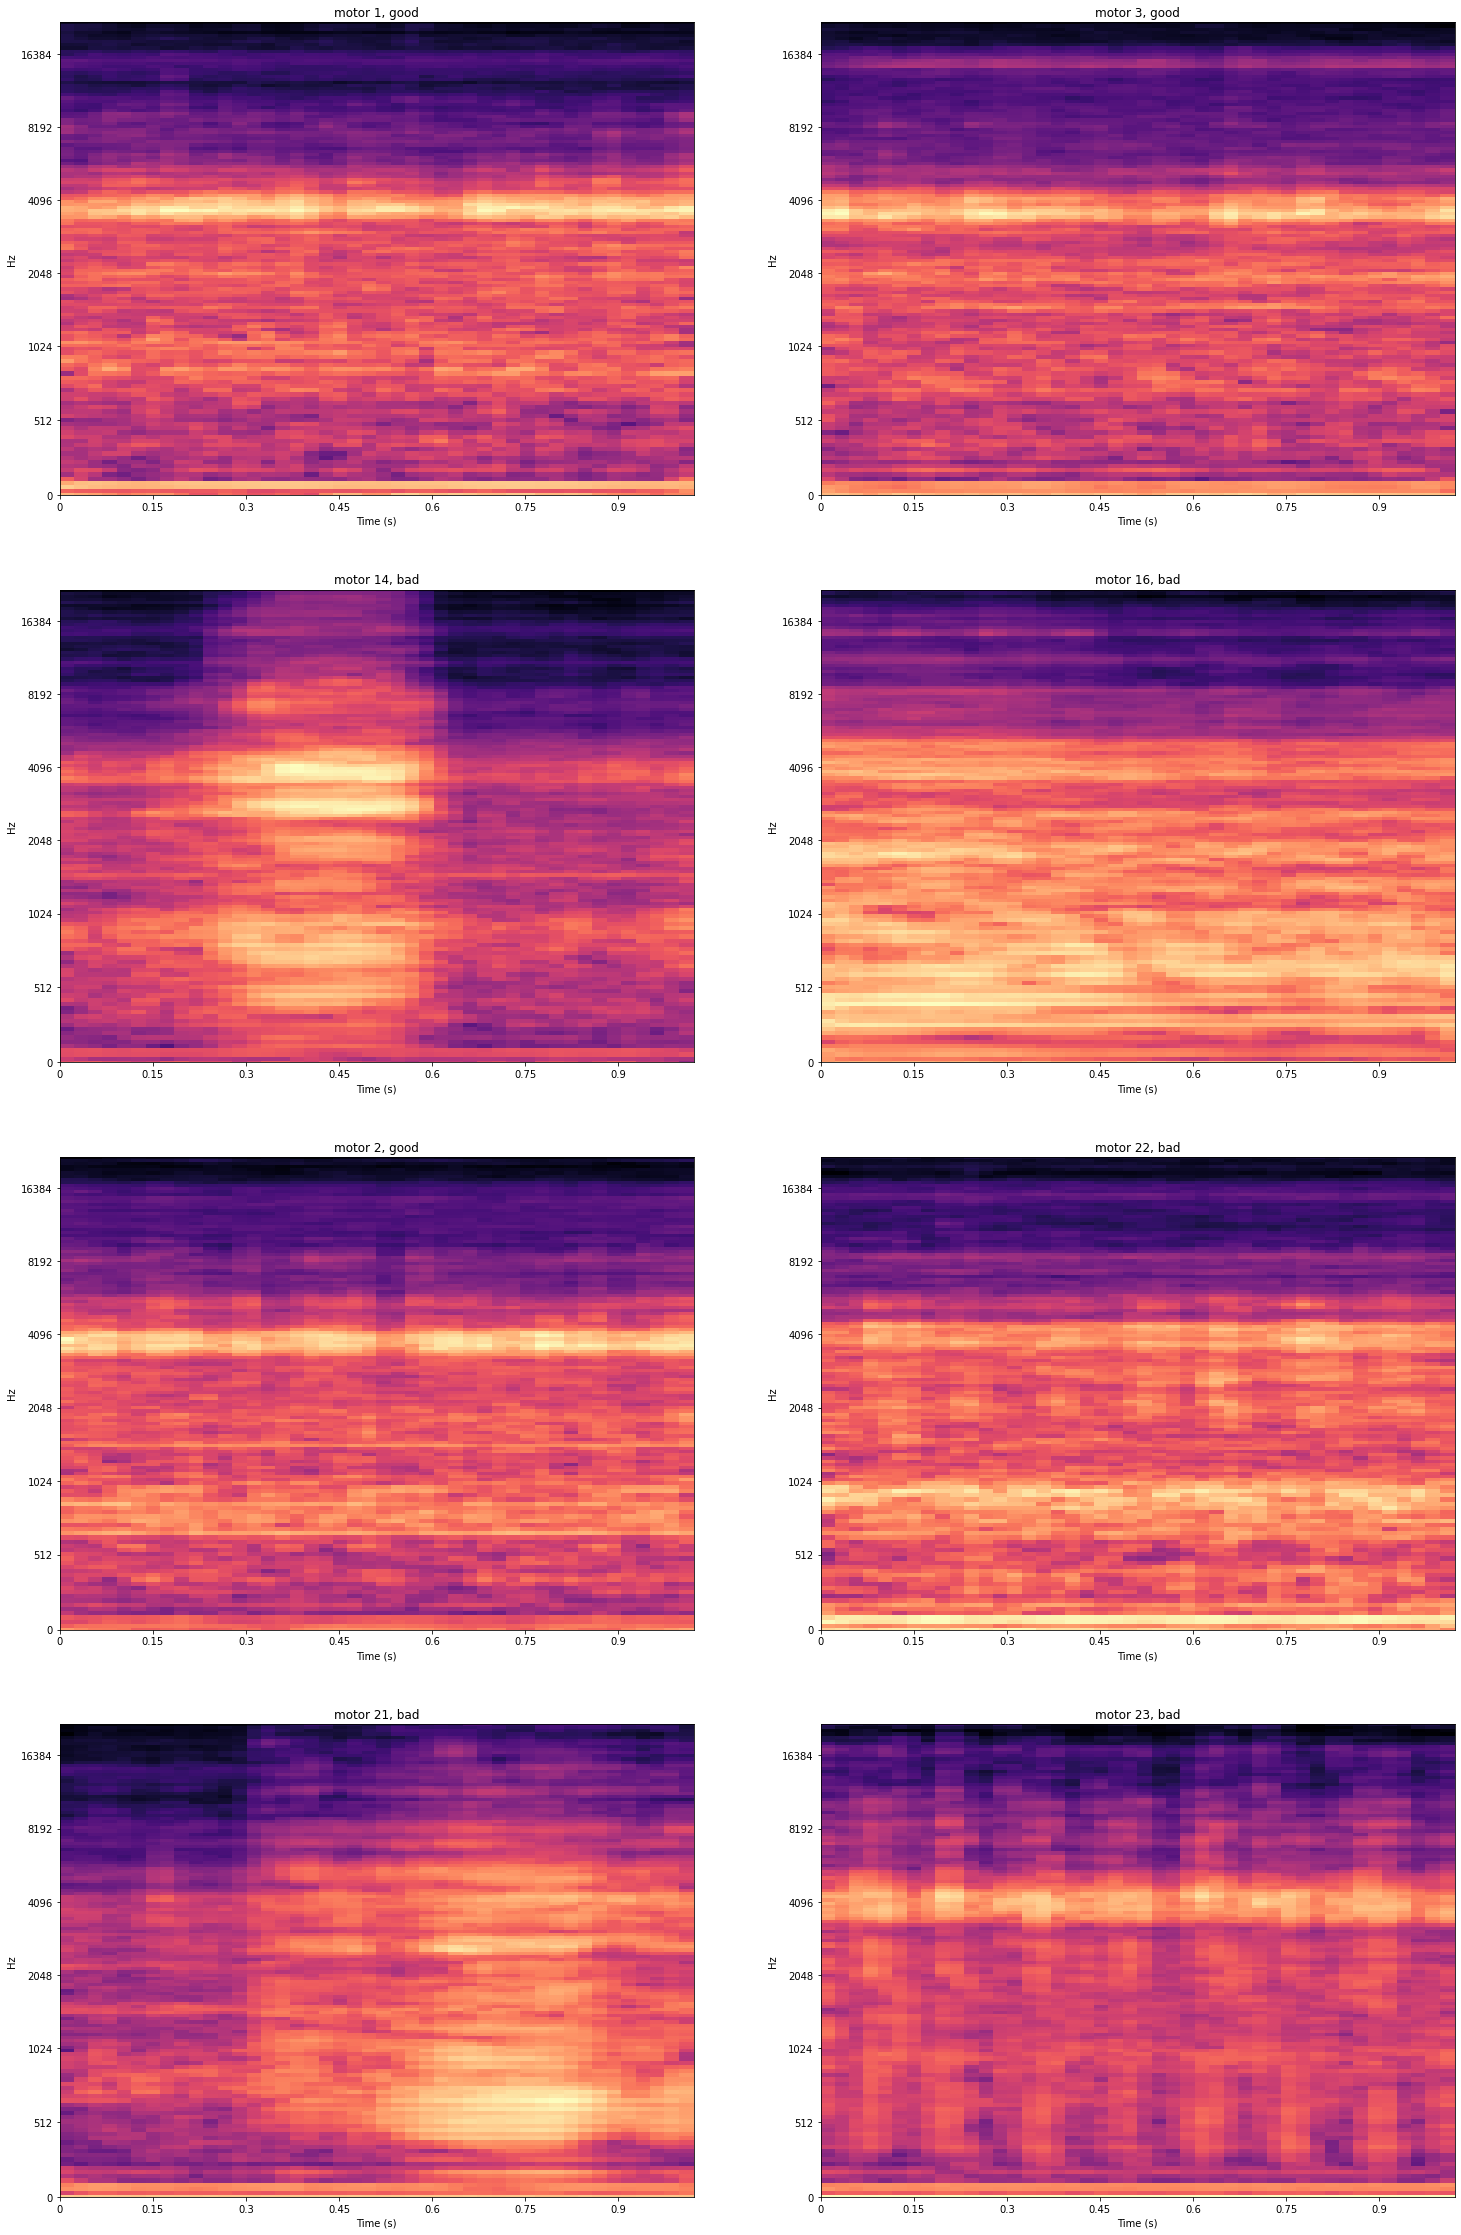

In [ ]:
compareSpectrograms(segments, 
                    compared_motorsIds = [1,3,14,16,2,22, 21,23],
                    n_fft=2**12,
                    hop_size=2**12//4,
                    n_mels=140,
                    segments_shift=20)

### Creating MelSpectrograms for all samples

In [ ]:
n_fft = 2**12
hop_length = n_fft // 4
n_mels = 140

for segment in segments:
    segment.createMelSpectrogram(n_mels, 
                                 n_fft=n_fft, 
                                 hop_length=hop_length, 
                                 samplerate=samplerate)
    # prepare flattened melspecs for saving locally
    segment.flattenMelSpectrogram()

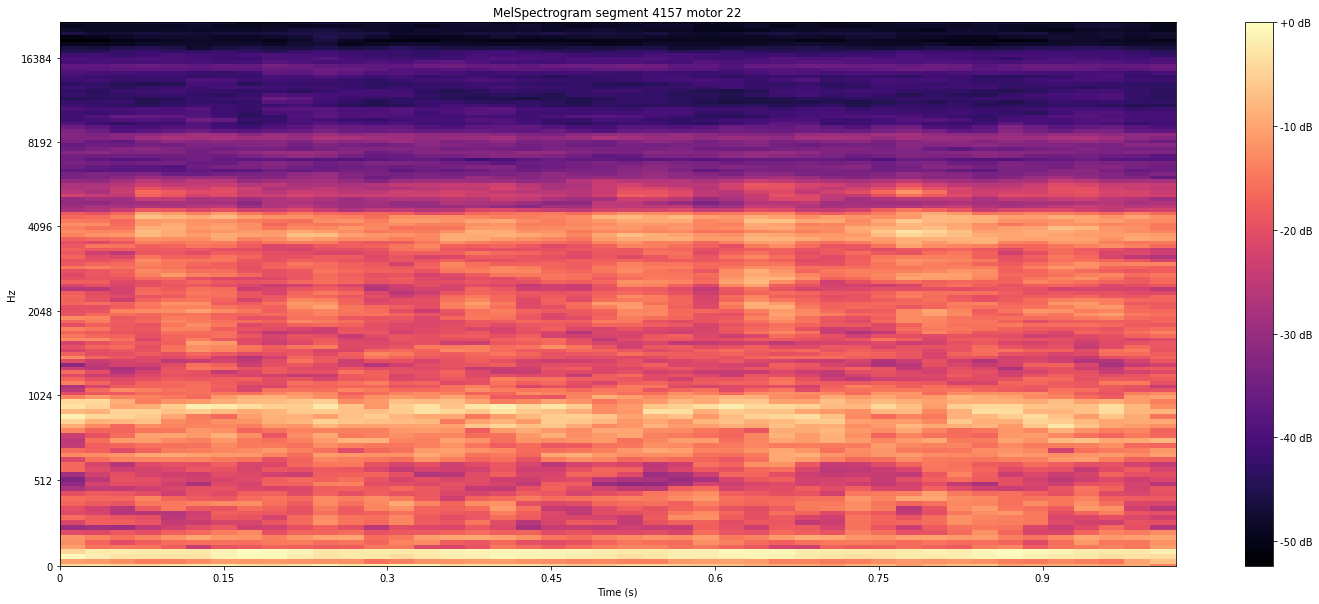

Shape: (140, 44)


In [ ]:
random_segment = np.random.randint(len(segments))
segment = segments[random_segment]

segment.displaySpectrogram(spec_type='mel',
                           title=f'MelSpectrogram segment {random_segment} motor {segment.motorId}',
                           hop_length=hop_length)

print(f"Shape: {segment.mel_spec_dB.shape}")

## Creating and saving input data as dataframes

In [ ]:
df_input_data = createSegmentsDF(segments, save_csv=True, filename='segments1sec')
saveMelSpecData(shape=segments[0].mel_spec_dB.shape, 
                n_fft=n_fft,
                hop_length=hop_length,
                filename="melSpec_data_1sec")
df_input_data.sample(10)


,motorId,isGood,0,1,2,3,4,5,6,7,...,6150,6151,6152,6153,6154,6155,6156,6157,6158,6159
1100,6,True,-10.879439,-11.136538,-13.068149,-17.148902,-16.499112,-15.759065,-13.556139,-12.682097,...,-52.183517,-52.057708,-53.075846,-53.914266,-53.480655,-53.231288,-53.161889,-53.349371,-53.031220,-53.590878
4338,23,False,-0.110584,-0.251089,-0.147136,0.000000,-0.092490,-0.197748,-0.317179,-0.236373,...,-57.890210,-60.543498,-62.434001,-64.068238,-67.269132,-62.878863,-63.133181,-63.652994,-64.576950,-69.598005
3200,17,False,-0.689173,-0.150666,0.000000,-0.504903,-0.786725,-0.934023,-0.839883,-0.262679,...,-61.930713,-61.486365,-64.112514,-64.492294,-62.890094,-62.404412,-63.391331,-62.676666,-62.654231,-63.553007
198,2,True,-19.614999,-17.590600,-17.591187,-19.230947,-20.068840,-20.309483,-21.747296,-22.358790,...,-52.462456,-52.717475,-52.559794,-52.899042,-53.822965,-53.514034,-53.212575,-53.867663,-53.666083,-51.859063
3735,19,False,-13.021772,-12.918204,-9.291918,-8.947921,-8.273972,-5.052414,-4.623157,-9.423103,...,-46.724728,-47.438076,-48.472598,-47.394545,-47.733886,-47.554767,-45.643971,-46.820637,-47.206638,-46.136842
2990,16,False,-6.915945,-9.693700,-9.794564,-10.959116,-12.166348,-10.624515,-9.837756,-11.038875,...,-53.230501,-53.344719,-53.635664,-52.984058,-52.259287,-52.081588,-53.211058,-54.168160,-53.453823,-51.423529
577,3,True,-5.038213,-6.211509,-6.431947,-5.725865,-6.363864,-7.618555,-6.771869,-5.930608,...,-52.290066,-51.841619,-50.821471,-51.289311,-51.623044,-51.943650,-53.310978,-54.143979,-53.329815,-53.132531
4357,23,False,0.000000,-0.144083,-0.240693,-0.214941,-0.176222,-0.142015,-0.282063,-0.337995,...,-65.702225,-66.372826,-63.557997,-58.414877,-60.190872,-66.723727,-65.866777,-58.772434,-58.648186,-64.129249
3393,18,False,-13.378199,-11.280105,-14.401046,-16.551067,-13.964882,-13.102396,-10.366444,-9.879303,...,-45.263974,-44.647249,-45.927346,-48.046654,-46.312030,-45.378377,-46.326218,-47.355741,-46.429043,-46.170269
628,4,True,-4.300659,-5.289235,-5.123158,-3.938482,-3.873854,-5.519275,-5.308943,-3.842659,...,-52.473200,-52.211748,-52.683976,-52.940024,-52.638417,-53.488645,-53.922862,-54.015136,-53.831042,-53.197019
